In [1]:
import sys
sys.path.append('../')
import shap
import torch
import cv2
from torch.utils.data import DataLoader
from mri_dataset_combined_shap import MRI_Dataset, MRI_Dataset_combined
from torchvision.models.efficientnet import efficientnet_v2_l, efficientnet_v2_m
import numpy 
import torchvision
from combined_classifier_shap import *
import matplotlib.pyplot as plt
from custom_image_shap import image as image_plot
import seaborn as sns



In [2]:
print(plt.style.available)
plt.style.use('seaborn-v0_8') 

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
#train_dataset = MRI_Dataset('/Users/olath/Documents/GitHub/Master-thesis/Datasets/train-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', transform=transform, slice= 12, orientation= 'AXIAL') 
train_dataset = MRI_Dataset_combined('/Users/olath/Documents/GitHub/Master-thesis/Datasets/train-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', device, slice= [12, 72, 43, 6, 58, 43])
val_dataset = MRI_Dataset_combined('/Users/olath/Documents/GitHub/Master-thesis/Datasets/val-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', device, slice= [12, 72, 43, 6, 58, 43])

#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_loader  = DataLoader(train_dataset, batch_size=512, shuffle=True)
validation_loader  = DataLoader(val_dataset, batch_size=512, shuffle=True)

#X, y = validation_loader()

In [4]:
#device = torch.device('mps' if torch.mps.is_available() else 'cpu')
#device = 'cpu'

#axial = efficientnet_v2_l(num_classes = 4)
#axial.load_state_dict(torch.load('/Users/olath/Downloads/model_12AXIAL_202503010344_best.pth', weights_only=True, map_location=torch.device('mps')))
#sagittal = efficientnet_v2_l(num_classes = 4)
#sagittal.load_state_dict(torch.load('/fp/homes01/u01/ec-olathor/Documents/thesis/model_72SAGITTAL_202502281601_best.pth', weights_only=True, map_location=torch.device('cuda')))
#coronal = efficientnet_v2_l(num_classes = 4)
#coronal.load_state_dict(torch.load('/fp/homes01/u01/ec-olathor/Documents/thesis/model_44CORONAL_202502280117_best.pth', weights_only=True, map_location=torch.device('cuda')))
#axial.eval()
#sagittal.eval()
#coronal.eval()  

axial1 = efficientnet_v2_m(num_classes = 3)
sagittal1 = efficientnet_v2_m(num_classes = 3)
coronal1 = efficientnet_v2_m(num_classes = 3)
axial2 = efficientnet_v2_m(num_classes = 2)
sagittal2 = efficientnet_v2_m(num_classes = 2)
coronal2 = efficientnet_v2_m(num_classes = 2)

#model = CombinedClassifierLogReg(4, axial, sagittal, coronal, device, dropout= 0.8, num_outputs = 1000)
#model.load_state_dict(torch.load('/Users/olath/Downloads/model_4class_202503071431_best.pth', weights_only=True, map_location=torch.device('mps'))
model = DoubleCombinedClassifierLogRegTest(4, axial1, sagittal1, coronal1, axial2, sagittal2, coronal2, dropout = 0.4, num_outputs = 250)
model.load_state_dict(torch.load('/Users/olath/Downloads/model_4classDouble_202503171605_best.pth', weights_only=True, map_location=torch.device('mps')))
model.to(device)
model.eval()

DoubleCombinedClassifierLogRegTest(
  (axial_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [5]:
def f(x):
    x = torch.from_numpy(x)
    #x = torch.clone(x)
    #x = torch.permute(x,(0, 3, 1, 2))
    return torch.softmax(model(x.to(device)), 1)


In [5]:
X, y = next(iter(validation_loader))
#X = X.to(device)

out = model(X[0], X[1], X[2], X[3], X[4], X[5], 'normal')

best_pred = 0
best_pred_index = 0

means = np.empty(len(out))

label_wanted = 2
for j in range (0, 1):
    out = model(X[0], X[1], X[2], X[3], X[4], X[5], 'normal')
    for i in range(0, len(out)):
        means[i] = out[i].cpu().detach().numpy().mean()
        if y[i] == label_wanted and (out[i].max() == out[i][label_wanted]):
            if out[i][label_wanted] > best_pred:
                best_pred = out[i][label_wanted]
                best_pred_index = i
    out = model(X[0], X[1], X[2], X[3], X[4], X[5], 'normal')

print(best_pred.cpu().detach().numpy())

out = model(X[0][best_pred_index:best_pred_index+1], X[1][best_pred_index:best_pred_index+1], X[2][best_pred_index:best_pred_index+1], 
            X[3][best_pred_index:best_pred_index+1], X[4][best_pred_index:best_pred_index+1], X[5][best_pred_index:best_pred_index+1], 'normal')

print(out)

out = out.cpu().detach().numpy().mean()


best_pred = best_pred.cpu().detach().numpy().round(4)

print(best_pred)

print(out)


0.9095268
tensor([[0.1514, 0.3770, 0.9095, 0.0609]], device='mps:0',
       grad_fn=<SigmoidBackward0>)
0.9095
0.37468588


In [8]:
X_train, y_train = next(iter(train_loader))

out = model(X[0], X[1], X[2], X[3], X[4], X[5], 'normal')

out = out.cpu().detach().numpy().mean()

print(out)

0.41586003


In [9]:
y_num = y[best_pred_index:best_pred_index+1].numpy()

labels = {0: 'True class: CN\n ' + str(out.round(4))+'/'+str(best_pred), 1:'True class: sMCI\n ' + str(out.mean().round(4))+'/'+str(best_pred), 2: 'True class: pMCI\n ' + str(out.mean().round(4))+'/'+str(best_pred), 3:'True class: AD\n ' + str(out.mean().round(4))+'/'+str(best_pred)}
true_labels = list()

for  label in y_num:    

    true_labels.append(labels[label])

In [ ]:
#X, y = next(iter(validation_loader))
#X_train, y_train = next(iter(train_loader))
#X, y = X.to(device), y.to(device)

#model(X)

#y_num = y[best_pred_index:best_pred_index+1].numpy()

#print(y_num)


#print(X[0][0], X[1][0], X[2][0])


#labels = {0: 'True class: CN', 1:'True class: sMCI', 2: 'True class: pMCI', 3:'True class: AD'}
#true_labels = list()

#for  label in y_num:    

#    true_labels.append(labels[label])

#print(true_labels)

#masker = shap.maskers.Image("blur(128,128)", X[0].shape)

#X = X.to(device)

# create an explainer with model and image masker
#explainer = shap.Explainer(f, masker)
explainer = shap.GradientExplainer(model, model(X_train[0], X_train[1], X_train[2], X_train[3], X_train[4], X_train[5], 'y_out'))

#print(X[1:3#].shape)

#
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values, shap_values_var = explainer.shap_values([X[0][best_pred_index:best_pred_index+1], X[1][best_pred_index:best_pred_index+1], X[2][best_pred_index:best_pred_index+1],
                                                      X[3][best_pred_index:best_pred_index+1], X[4][best_pred_index:best_pred_index+1], X[5][best_pred_index:best_pred_index+1]], nsamples = 25, return_variances= True)

6
1
(3, 100, 100, 4)


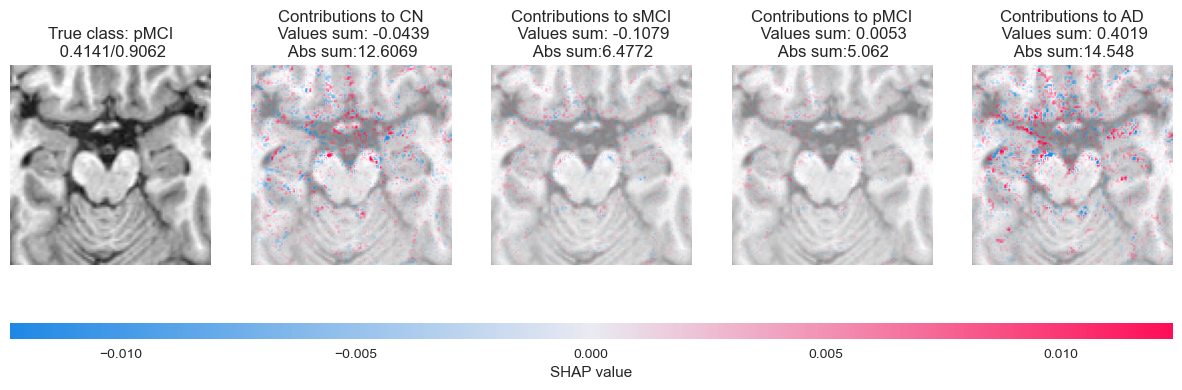

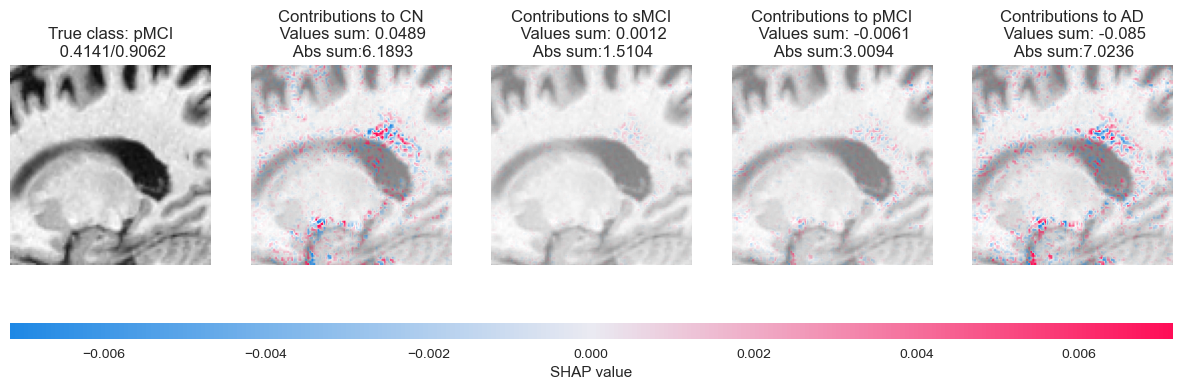

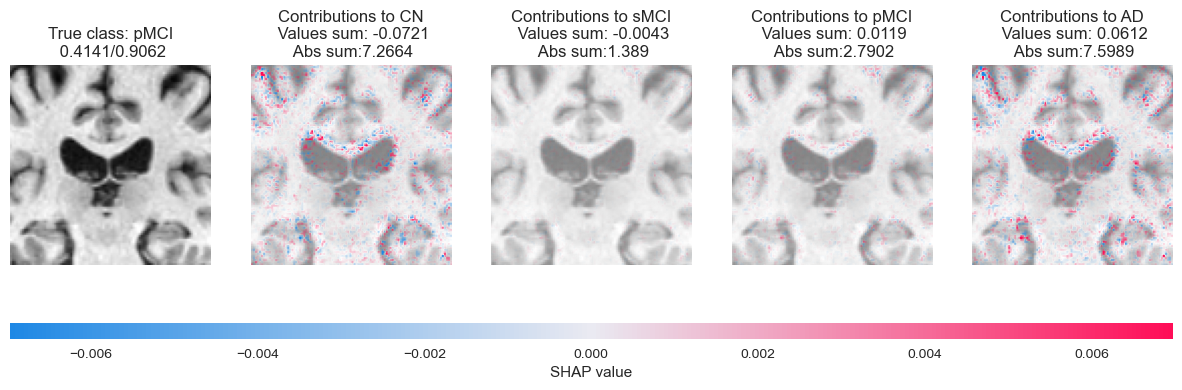

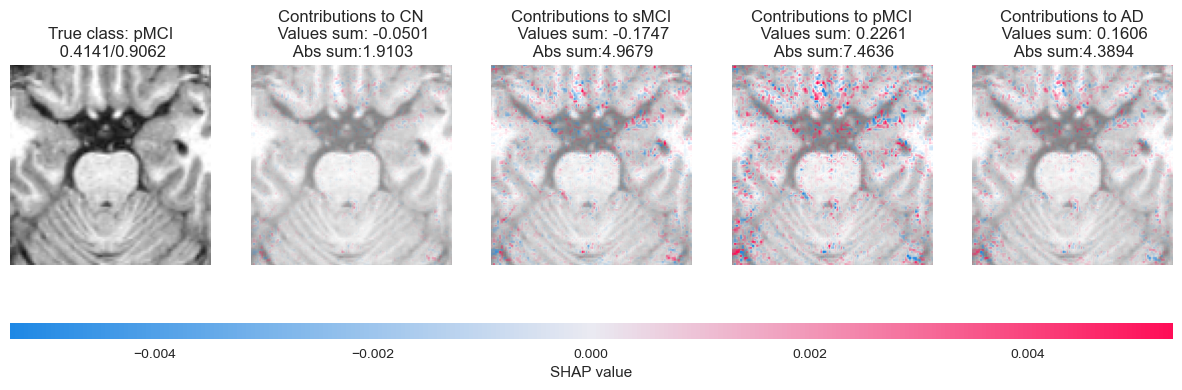

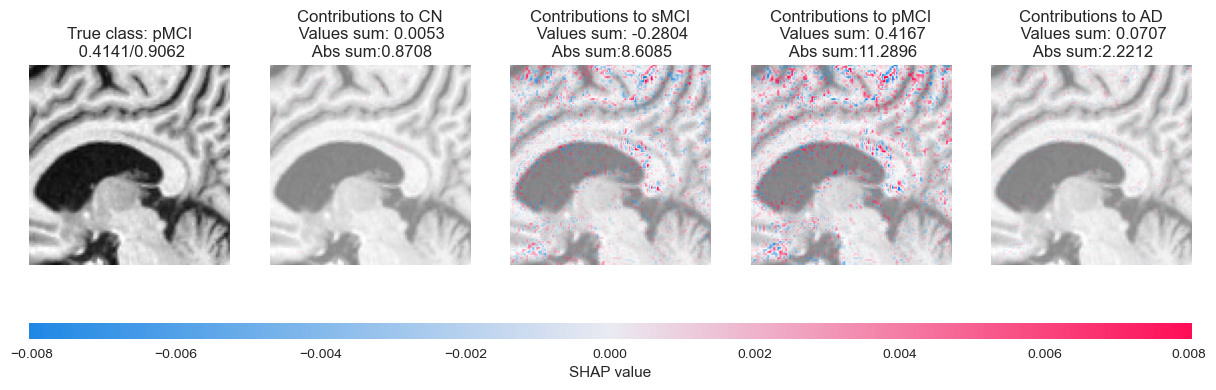

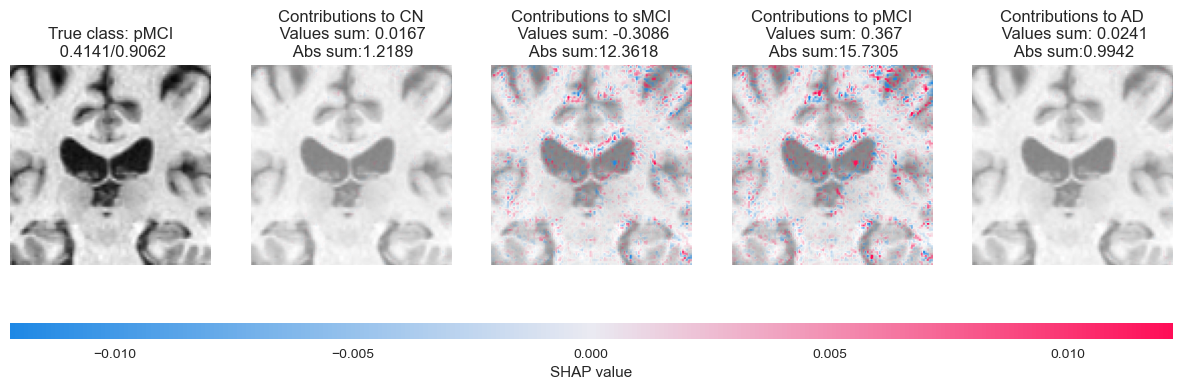

In [10]:
print(len(shap_values))
print(len(shap_values[0]))
print(shap_values[0][0].shape)

display_img1 = torch.permute(X[0][0].cpu(), (1, 2, 0)).numpy()
display_img2 = torch.permute(X[1][0].cpu(), (1, 2, 0)).numpy()
display_img3 = torch.permute(X[2][0].cpu(), (1, 2, 0)).numpy()
display_img4 = torch.permute(X[3][0].cpu(), (1, 2, 0)).numpy()
display_img5 = torch.permute(X[4][0].cpu(), (1, 2, 0)).numpy()
display_img6 = torch.permute(X[5][0].cpu(), (1, 2, 0)).numpy()

display_val1 = np.transpose(shap_values[0], (4, 0, 2, 3, 1))
display_val2 = np.transpose(shap_values[1], (4, 0, 2, 3, 1))
display_val3 = np.transpose(shap_values[2], (4, 0, 2, 3, 1))
display_val4 = np.transpose(shap_values[3], (4, 0, 2, 3, 1))
display_val5 = np.transpose(shap_values[4], (4, 0, 2, 3, 1))
display_val6 = np.transpose(shap_values[5], (4, 0, 2, 3, 1))

image_plot([display_val1[i][0] for i in range(4)], display_img1, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([display_val2[i][0] for i in range(4)], display_img2, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([display_val3[i][0] for i in range(4)], display_img3, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([display_val4[i][0] for i in range(4)], display_img4, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([display_val5[i][0] for i in range(4)], display_img5, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([display_val6[i][0] for i in range(4)], display_img6, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)



['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd']
(3, 100, 100, 4)
102.21054224480145


Text(0.5, 1.0, 'Sum of contributions of separate orientations to all model outputs for a predicted pMCI patient')

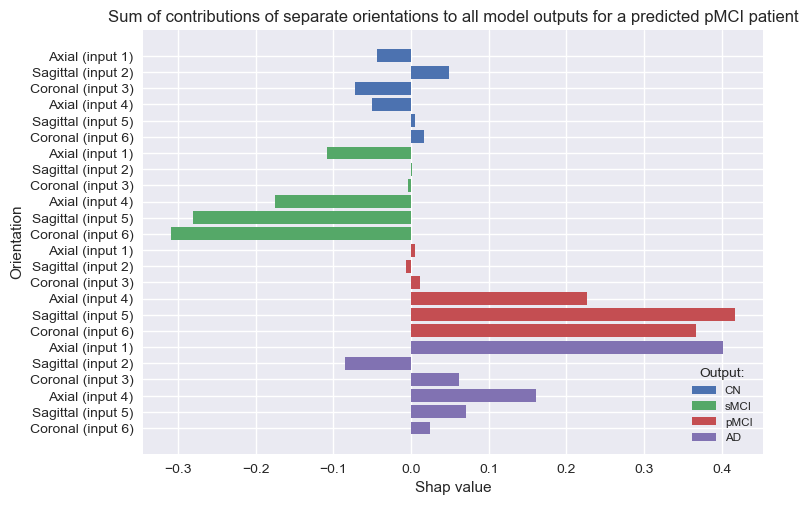

In [28]:
print(sns.color_palette().as_hex())

print(shap_values[0][0].shape)

category_names = ['CN', 'sMCI', 'pMCI','AD']

value_axial = np.transpose(shap_values[0][0], (3 ,0, 1, 2))
value_sagittal = np.transpose(shap_values[1][0], (3 ,0, 1, 2))
value_coronal = np.transpose(shap_values[2][0], (3 ,0, 1, 2))
value_axial2 = np.transpose(shap_values[3][0], (3 ,0, 1, 2))
value_sagittal2 = np.transpose(shap_values[4][0], (3 ,0, 1, 2))
value_coronal2 = np.transpose(shap_values[5][0], (3 ,0, 1, 2))

#print(value_axial[0].sum().round(4))
#print(value_sagittal[0].sum().round(4))
#print(value_coronal[0].sum().round(4))

np.random.seed(19680801)

fig, ax = plt.subplots()

# Example data
people = ('Axial (input 1)', 'Sagittal (input 2)', 'Coronal (input 3)','Axial (input 4)', 'Sagittal (input 5)', 'Coronal (input 6)',
          'Axial (input 1)', 'Sagittal (input 2)', 'Coronal (input 3)','Axial (input 4)', 'Sagittal (input 5)', 'Coronal (input 6)',
          'Axial (input 1)', 'Sagittal (input 2)', 'Coronal (input 3)','Axial (input 4)', 'Sagittal (input 5)', 'Coronal (input 6)',
          'Axial (input 1)', 'Sagittal (input 2)', 'Coronal (input 3)','Axial (input 4)', 'Sagittal (input 5)', 'Coronal (input 6)')
y_pos = np.arange(len(people))

print(np.abs(value_axial[0]).sum())

sum_performance = [value_axial[0].sum().round(4),value_sagittal[0].sum().round(4),value_coronal[0].sum().round(4),
               value_axial2[0].sum().round(4),value_sagittal2[0].sum().round(4),value_coronal2[0].sum().round(4),
               value_axial[1].sum().round(4),value_sagittal[1].sum().round(4),value_coronal[1].sum().round(4),
               value_axial2[1].sum().round(4),value_sagittal2[1].sum().round(4),value_coronal2[1].sum().round(4),
               value_axial[2].sum().round(4),value_sagittal[2].sum().round(4),value_coronal[2].sum().round(4),
               value_axial2[2].sum().round(4),value_sagittal2[2].sum().round(4),value_coronal2[2].sum().round(4),
               value_axial[3].sum().round(4),value_sagittal[3].sum().round(4),value_coronal[3].sum().round(4),
               value_axial2[3].sum().round(4),value_sagittal2[3].sum().round(4),value_coronal2[3].sum().round(4)]

abs_performance = [np.abs(value_axial[0]).sum().round(4),np.abs(value_sagittal[0]).sum().round(4),np.abs(value_coronal[0]).sum().round(4),
               np.abs(value_axial2[0]).sum().round(4),np.abs(value_sagittal2[0]).sum().round(4),np.abs(value_coronal2[0]).sum().round(4),
               np.abs(value_axial[1]).sum().round(4),np.abs(value_sagittal[1]).sum().round(4),np.abs(value_coronal[1]).sum().round(4),
               np.abs(value_axial2[1]).sum().round(4),np.abs(value_sagittal2[1]).sum().round(4),np.abs(value_coronal2[1]).sum().round(4),
               np.abs(value_axial[2]).sum().round(4),np.abs(value_sagittal[2]).sum().round(4),np.abs(value_coronal[2]).sum().round(4),
               np.abs(value_axial2[2]).sum().round(4),np.abs(value_sagittal2[2]).sum().round(4),np.abs(value_coronal2[2]).sum().round(4),
               np.abs(value_axial[3]).sum().round(4),np.abs(value_sagittal[3]).sum().round(4),np.abs(value_coronal[3]).sum().round(4),
               np.abs(value_axial2[3]).sum().round(4),np.abs(value_sagittal2[3]).sum().round(4),np.abs(value_coronal2[3]).sum().round(4)]

bar_colors = ['tab:red', 'tab:blue', 'tab:green']

#ax.barh(y_pos[0:3], [sum(performance[0:3]),sum(performance[0:3]),sum(performance[0:3])], align='center', alpha = 0.25, height = 1)
#ax.barh(y_pos[3:6], [sum(performance[3:6]),sum(performance[3:6]),sum(performance[3:6])], align='center', alpha = 0.25, height = 1)
#ax.barh(y_pos[6:9], [sum(performance[6:9]),sum(performance[6:9]),sum(performance[6:9])], align='center', alpha = 0.25, height = 1)
#ax.barh(y_pos[9:12], [sum(performance[9:12]),sum(performance[9:12]),sum(performance[9:12])], align='center', alpha = 0.25, height = 1)
ax.barh(y_pos[0:6], sum_performance[0:6], align='center', label = category_names[0], color = '#4c72b0')
ax.barh(y_pos[6:12], sum_performance[6:12], align='center', label = category_names[1], color = '#55a868')
ax.barh(y_pos[12:18], sum_performance[12:18], align='center', label = category_names[2], color = '#c44e52')
ax.barh(y_pos[18:24], sum_performance[18:24], align='center', label = category_names[3], color = '#8172b2')



ax.set_yticks(y_pos, labels=people)
ax.legend(ncols=1,loc='lower right', fontsize='small', title = 'Output:')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Shap value')
ax.set_ylabel('Orientation')
ax.set_title('Sum of contributions of separate orientations to all model outputs for a predicted pMCI patient')





NameError: name 'y_pos' is not defined

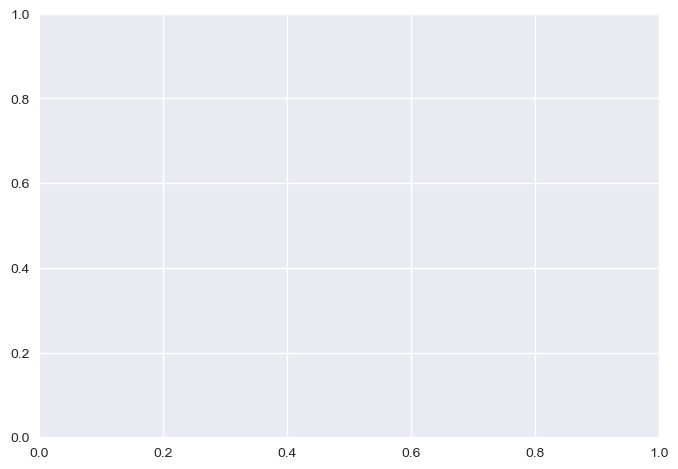

In [10]:
fig, ax = plt.subplots()

ax.scatter(y_pos[0:6], abs_performance[0:6], align='center', label = category_names[0], color = '#4c72b0')
ax.barh(y_pos[6:12], abs_performance[6:12], align='center', label = category_names[1], color = '#55a868')
ax.barh(y_pos[12:18], abs_performance[12:18], align='center', label = category_names[2], color = '#c44e52')
ax.barh(y_pos[18:24], abs_performance[18:24], align='center', label = category_names[3], color = '#8172b2')



ax.set_yticks(y_pos, labels=people)
ax.legend(ncols=1,loc='lower right', fontsize='small', title = 'Output:')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Shap value')
ax.set_ylabel('Orientation')
ax.set_title('Absolute sum of contributions of separate orientations to all model outputs for a predicted pMCI patient')



In [13]:
#print(len(shap_values))
print(len(shap_values_var))
print(len(shap_values_var[0]))
print(shap_values_var[0][0].shape)

display_img1 = torch.permute(X[0][0].cpu(), (1, 2, 0)).numpy()
display_img2 = torch.permute(X[1][0].cpu(), (1, 2, 0)).numpy()
display_img3 = torch.permute(X[2][0].cpu(), (1, 2, 0)).numpy()
display_img4 = torch.permute(X[3][0].cpu(), (1, 2, 0)).numpy()
display_img5 = torch.permute(X[4][0].cpu(), (1, 2, 0)).numpy()
display_img6 = torch.permute(X[5][0].cpu(), (1, 2, 0)).numpy()

display_val1 = np.transpose(shap_values_var[0], (4, 0, 2, 3, 1))
display_val2 = np.transpose(shap_values_var[1], (4, 0, 2, 3, 1))
display_val3 = np.transpose(shap_values_var[2], (4, 0, 2, 3, 1))
display_val4 = np.transpose(shap_values_var[3], (4, 0, 2, 3, 1))
display_val5 = np.transpose(shap_values_var[4], (4, 0, 2, 3, 1))
display_val6 = np.transpose(shap_values_var[5], (4, 0, 2, 3, 1))


image_plot([shap_values_var[i][0][0].transpose(1, 2, 0) for i in range(4)], display_img1, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][1][0].transpose(1, 2, 0) for i in range(4)], display_img2, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][2][0].transpose(1, 2, 0) for i in range(4)], display_img3, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][3][0].transpose(1, 2, 0) for i in range(4)], display_img4, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][4][0].transpose(1, 2, 0) for i in range(4)], display_img5, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][5][0].transpose(1, 2, 0) for i in range(4)], display_img6, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)

4
6
(1, 3, 100, 100)


IndexError: list index out of range

Text(0.5, 1.0, 'Contributions of each orientation on the predicted probability of each class')

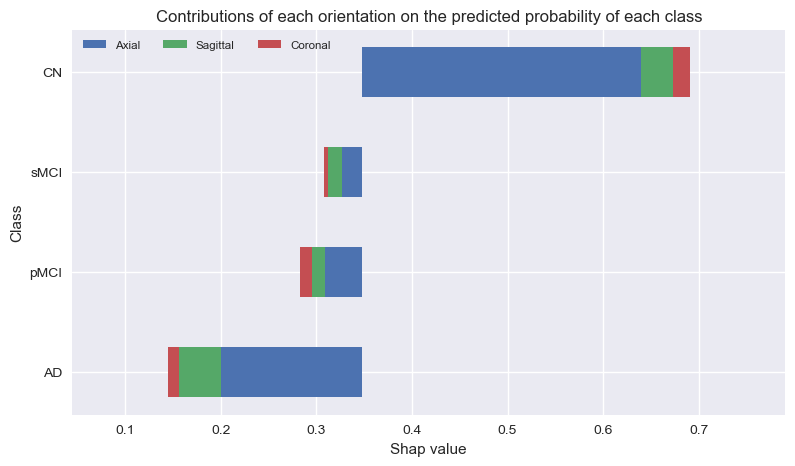

In [ ]:
category_names = ['Axial', 'Sagittal', 'Coronal']
results = {'CN': [value_axial[0].sum().round(4),value_sagittal[0].sum().round(4),value_coronal[0].sum().round(4)],
          'sMCI': [value_axial[1].sum().round(4),value_sagittal[1].sum().round(4),value_coronal[1].sum().round(4)],
          'pMCI': [value_axial[2].sum().round(4),value_sagittal[2].sum().round(4),value_coronal[2].sum().round(4)],
          'AD': [value_axial[3].sum().round(4),value_sagittal[3].sum().round(4),value_coronal[3].sum().round(4)]}

labels = list(results.keys())
data = np.array(list(results.values()))
data_cum = data.cumsum(axis=1)
category_colors = plt.colormaps['RdYlGn'](
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(9.2, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(True)
ax.set_xlim(np.sum(data, axis=1).min()-0.1 + out, np.sum(data, axis=1).max()+0.1 + out)

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i] 
    starts = data_cum[:, i] - widths + out
    rects = ax.barh(labels, widths, left=starts, height=0.5,
                    label=colname)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    #ax.bar_label(rects, label_type='center', color=text_color)
ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
        loc='upper left', fontsize='small')

ax.set_xlabel('Shap value')
ax.set_ylabel('Class')
ax.set_title('Contributions of each orientation on the predicted probability of each class')

In [ ]:
# Prepare data transformation pipeline
                        
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * numpy.array(mean) / numpy.array(std)).tolist(),
        std=(1 / numpy.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [ ]:
shap_values_data = inv_transform(shap_values.data).cpu().numpy()
shap_values_values = [val for val in numpy.moveaxis(shap_values.values, -1, 0)]


AttributeError: 'list' object has no attribute 'data'

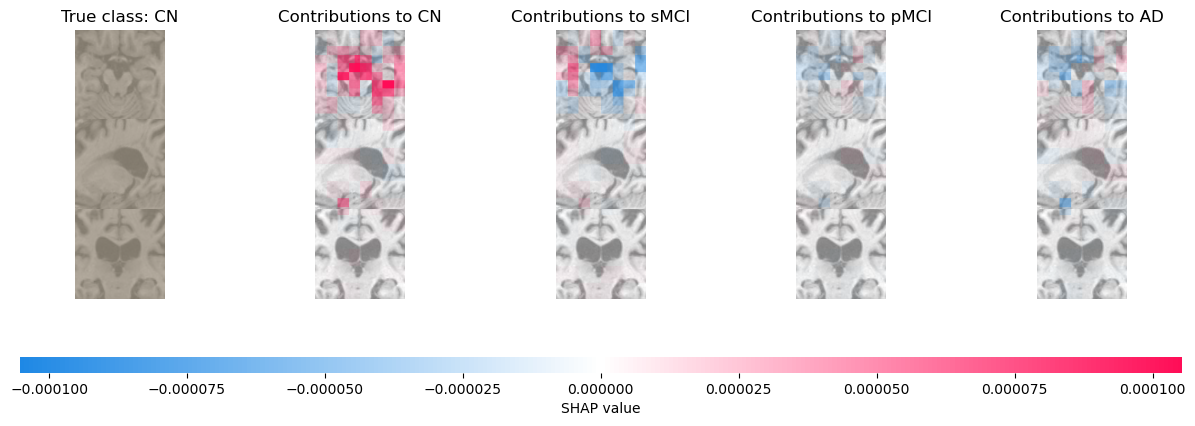

In [ ]:
image_plot(
    shap_values=shap_values_values,
    pixel_values=shap_values_data,
    labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'],
    true_labels = true_labels,
    show = False
)

plt.savefig("test.png", dpi = 1200) 

In [ ]:
values = shap_values.values
data = shap_values.data

In [ ]:
data_num = data.numpy()
data_scaled = data_num/data_num.max()
values2 = values + 2626.385322093757
values_scaled = values2/values2.max()
print(data_scaled.max())
print(values_scaled.max())

1.0
1.0


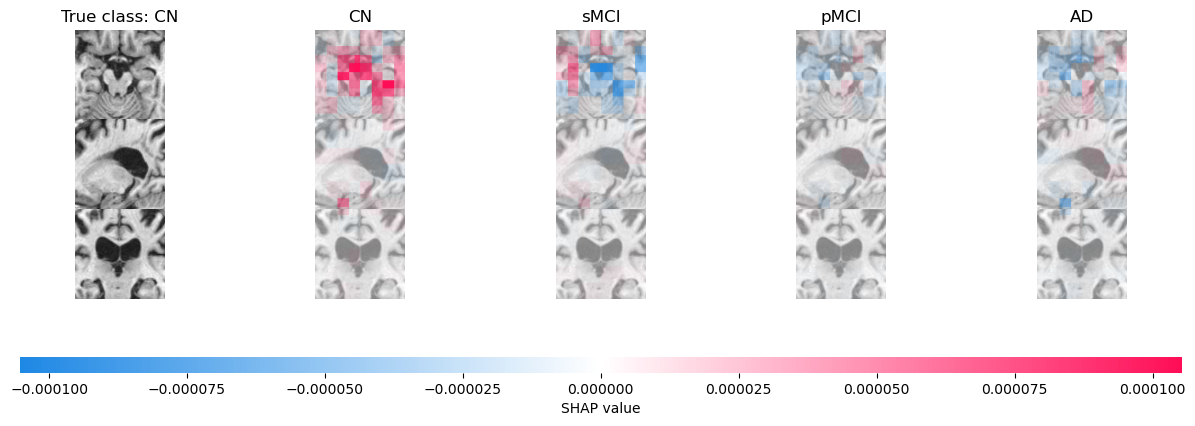

In [ ]:
image_plot(
    shap_values=shap_values_values,
    pixel_values=data_scaled,
    labels = ['CN', 'sMCI', 'pMCI', 'AD'],
    true_labels = true_labels
)

In [ ]:
test = shap_values.values[0]
test.shape
test2 = test.reshape(4, 3, 300, 100)
test3 = shap_values_values[0][0].reshape(3, 100, 100, 3)
print(shap_values_values[0].sum())
print(shap_values_values[1].sum())
print(shap_values_values[2].sum())
print(shap_values_values[3].sum())

print(shap_values_values[0].sum()-shap_values_values[1].sum()-shap_values_values[2].sum()-shap_values_values[3].sum())

0.21183383464813232
-0.07443493604660037
-0.05520151555538178
-0.08219747245311737
0.4236677587032318


In [ ]:
arr = numpy.array([0.45553565,0.18600965,0.17938341,0.17907123])
shap_values_values[1].sum() + arr.mean()


0.17556504895339964